In [1]:
import scanpy as sc
import sys
sys.path.append("/home/zflu/multiomics")
adata_RNA = sc.read_h5ad('/home/zflu/Benchmark/strong/Dataset/Yao-2021/Yao-2021-RNA.h5ad')
adata_ATAC = sc.read_h5ad('/home/zflu/Benchmark/strong/Dataset/Yao-2021/Yao-2021-FRAGS2RNA.h5ad')

In [2]:
# 取交集基因并对齐
cm_genes = sorted(list(set(adata_ATAC.var_names) & set(adata_RNA.var_names)))
adata_RNA = adata_RNA[:, cm_genes]
adata_ATAC = adata_ATAC[:, cm_genes]

# 计算高变基因
sc.pp.highly_variable_genes(adata_RNA, flavor='seurat_v3', n_top_genes=1000)
sc.pp.highly_variable_genes(adata_ATAC, flavor='seurat_v3', n_top_genes=1000)

# 取共同的高变基因
shared_genes = adata_RNA.var_names[adata_RNA.var.highly_variable | adata_ATAC.var.highly_variable]
shared_genes = list(shared_genes)

adata_RNA = adata_RNA[:,shared_genes].copy()
adata_ATAC = adata_ATAC[:,shared_genes].copy()

sc.pp.normalize_total(adata_RNA)
sc.pp.log1p(adata_RNA)

sc.pp.normalize_total(adata_ATAC)
sc.pp.log1p(adata_ATAC)

/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:151: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": "seurat_v3"}
/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:151: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": "seurat_v3"}


In [3]:
import mycode
sc.pp.scale(adata_RNA, max_value=10)
sc.pp.scale(adata_ATAC, max_value=10)
#mycode.utils.batch_scale(adata_RNA,method='standard')
#mycode.utils.batch_scale(adata_ATAC,method='standard')

In [4]:
model = mycode.Model(adata_RNA, adata_ATAC, batch_size=500, 
                           training_steps=12000, seed=1234, celltype_col='cell_type',source_col=None,
                            n_latent=16, lambdaRecon = 10.0, lambdaLA = 10.0, loss_type='MSE',
                            lambdaOT = 1.0, lambdamGAN = 1.0, lambdabGAN = 1.0, n_KNN = 30, lambdaGeo=0.1, mode = 'strong', use_prior = True)

In [5]:
model.train()
model.eval()

Training started at: Tue Sep  2 14:28:00 2025
Step 0 | Recon: 19.3750 | LA: 55.3840 | OT: 22.6636 | Geo: 17.9072 | mGAN: -1.3960 | bGAN: -0.0000
Step 1000 | Recon: 14.0046 | LA: 0.0286 | OT: 0.1304 | Geo: 0.1755 | mGAN: -1.3821 | bGAN: -0.0000
Step 2000 | Recon: 13.8771 | LA: 0.0192 | OT: 0.0960 | Geo: 0.1223 | mGAN: -1.3780 | bGAN: -0.0000
Step 3000 | Recon: 13.8320 | LA: 0.0185 | OT: 0.0995 | Geo: 0.1190 | mGAN: -1.3793 | bGAN: -0.0000
Step 4000 | Recon: 13.9039 | LA: 0.0148 | OT: 0.0860 | Geo: 0.1246 | mGAN: -1.3831 | bGAN: -0.0000
Step 5000 | Recon: 13.9618 | LA: 0.0196 | OT: 0.0893 | Geo: 0.1188 | mGAN: -1.3854 | bGAN: -0.0000
Step 6000 | Recon: 13.8386 | LA: 0.0165 | OT: 0.0940 | Geo: 0.1111 | mGAN: -1.3830 | bGAN: -0.0000
Step 7000 | Recon: 13.8575 | LA: 0.0129 | OT: 0.0846 | Geo: 0.1046 | mGAN: -1.3832 | bGAN: -0.0000
Step 8000 | Recon: 13.8049 | LA: 0.0126 | OT: 0.0831 | Geo: 0.1044 | mGAN: -1.3857 | bGAN: -0.0000
Step 9000 | Recon: 13.6751 | LA: 0.0120 | OT: 0.0839 | Geo: 0.1

In [6]:
import anndata as ad
import pandas as pd
adata_integrated = ad.AnnData(X=model.latent)
adata_integrated.obs = pd.concat([adata_RNA.obs, adata_ATAC.obs])
adata_integrated.obs['modality'] = ['RNA'] * adata_RNA.shape[0] + ['ATAC'] * adata_ATAC.shape[0]

In [7]:
sc.pp.neighbors(adata_integrated)
sc.tl.umap(adata_integrated, min_dist=0.3)

/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(c

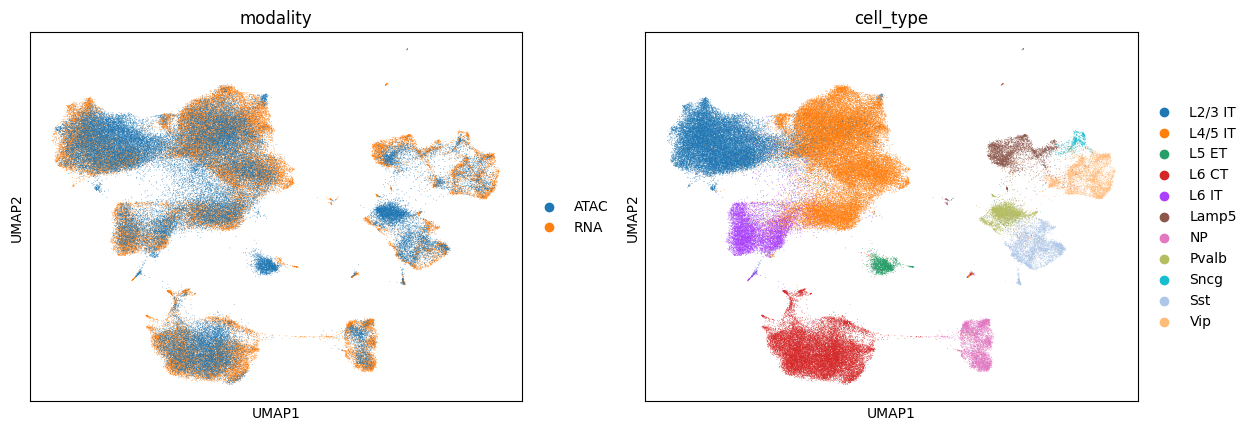

In [8]:
sc.pl.umap(adata_integrated, color=['modality','cell_type'])

In [ ]:
import numpy as np
sc.pp.pca(adata_RNA)
sc.pp.pca(adata_ATAC)
X = model.latent
y = np.concatenate([adata_RNA.obsm['X_pca'], adata_ATAC.obsm['X_pca']], axis=0)
ct = pd.concat([adata_RNA.obs['cell_type'], adata_ATAC.obs['cell_type']]).to_numpy()
batch = np.array(['RNA']*adata_RNA.shape[0] + ['ATAC']*adata_ATAC.shape[0])
map_score = mycode.metrics.mean_average_precision(X, ct)
asw_celltype = mycode.metrics.avg_silhouette_width(X, ct)
nc = mycode.metrics.neighbor_conservation(X, y, batch)
asw_batch = mycode.metrics.avg_silhouette_width_batch(X, batch, ct)
sas = mycode.metrics.seurat_alignment_score(X, batch)
gc = mycode.metrics.graph_connectivity(X, batch)

print("MAP:", map_score)
print("ASW_celltype:", asw_celltype)
print("NC:", nc)
print("ASW_batch:", asw_batch)
print("SAS:", sas)
print("GC:", gc)

/home/zflu/miniconda3/envs/py310/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MAP: 0.9220365680194805
ASW_celltype: 0.5869011282920837
NC: 0.2972255233536047
ASW_batch: 0.9163851141929626
SAS: 0.7958266413323027
GC: 0.9972514256573265


/home/zflu/multiomics/mycode/metrics.py:290: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts = pd.value_counts(c)
